# Structuring Boosted Trees

The main aim of this notebook is to show how to use 

- interaction constraints and
- monotonic constraints

to bring structure into boosted trees models.

We use typical XAI methods like TreeSHAP, partial dependence plots (PDP) and individual conditional expectation (ICE) plots to visualize the effect of the constraints.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

## Load data

We will use a motor third-part liability (MTPL) pricing dataset that describes 1 Mio insurance policies and their corresponding claim counts, see Mayer, M., Meier, D. and Wuthrich, M.V. (2023) SHAP for Actuaries: Explain any Model. http://dx.doi.org/10.2139/ssrn.4389797. The dataset was synthetically generated, see above link for the underlying true model. It can also be downloaded from https://www.openml.org/search?type=data&status=active&id=45106.

We will model claim counts (`claim_nb`) as a function of the other columns.

In [35]:
if False:  # Fetch from OpenML
    from sklearn.datasets import fetch_openml
    
    df0 = fetch_openml(data_id=45106, as_frame=True)
    df = df0.data
    df["claim_nb"] = df0.target
else:     # Fetch from repo
    df = pd.read_parquet("df.parquet")
df

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0
...,...,...,...,...,...,...,...
999995,2019.0,1.0,45.0,1090.0,62.0,2.0,0
999996,2019.0,1.0,45.0,1180.0,93.0,4.0,0
999997,2018.0,1.0,31.0,1060.0,57.0,1.0,0
999998,2019.0,1.0,28.0,1910.0,149.0,0.0,0


## Describe data

Let's first describe the distribution of each column univariately.

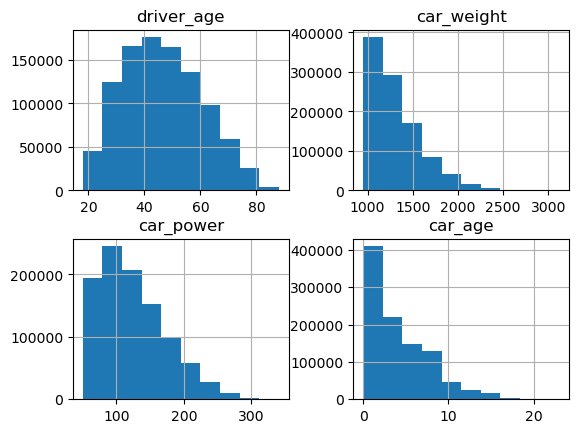

In [36]:
_ = df.hist(["driver_age", "car_weight", "car_power", "car_age"])

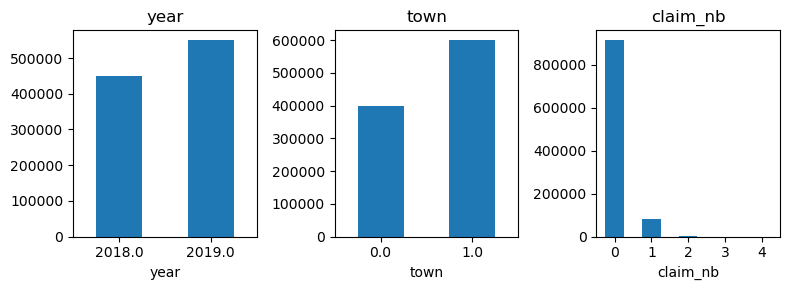

In [37]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["year", "town", "claim_nb"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)

plt.tight_layout()
plt.show()

## Data split

We will use 90% of the data to build the models and keep 10% untouched as test data.

In [38]:
from sklearn.model_selection import train_test_split

y_train, y_test, X_train, X_test = train_test_split(
    df["claim_nb"], df.drop("claim_nb", axis=1), test_size=0.1, random_state=30
)

## A first model

Let's fit a Poisson regression for the claim count via LightGBM. The number of trees is chosen via early stopping on the cross-validation (CV) performance. Other important hyper-parameters are selected by trial and error (also via CV).

In [39]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

dtrain = lgb.Dataset(X_train, label=y_train)

### Parameter tuning

In [40]:
params = dict(
    learning_rate=0.05,
    objective="poisson",
    metric="poisson",
    num_leaves=7,
    min_child_samples=50,
    min_child_weight=0.001,
    colsample_bynode=0.8,
    subsample=0.8,
    reg_alpha=3,
    reg_lambda=5,
    verbose=-1,
)

if False:  # Set to True to re-run CV
    cvm = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        nfold=5,
        callbacks=[lgb.log_evaluation(period=10), lgb.early_stopping(20, verbose=0)],
    )

    num_rounds = len(cvm["valid poisson-mean"])
    num_rounds, cvm["valid poisson-mean"][num_rounds - 1]
else:
    num_rounds = 360

### Fit with best parameters

Note that we use LightGBM's Scikit-Learn interface to fit the model. This has the advantage to use it together with a preprocessor (not necessary here), and that we can directly use Scikit-Learn's inspection module.

In [41]:
# model = lgb.train(params, train_set=dtrain, num_boost_round=num_rounds)  # Native API
model = LGBMRegressor(n_estimators=num_rounds, **params, n_jobs=7)         # Scikit-Learn API
model.fit(X_train, y_train)

LGBMRegressor(colsample_bynode=0.8, learning_rate=0.05, metric='poisson',
              min_child_samples=50, n_estimators=360, n_jobs=7, num_leaves=7,
              objective='poisson', reg_alpha=3, reg_lambda=5, subsample=0.8,
              verbose=-1)

### SHAP analysis

Let's use TreeSHAP to decompose 2000 training observations into the contributions of the features. Note that this is done on the log link scale.

In [42]:
X_explain = X_train.sample(n=2000, random_state=937)

In [43]:
import shap

explainer = shap.Explainer(model)
shap_val = explainer(X_explain)

#### SHAP importance

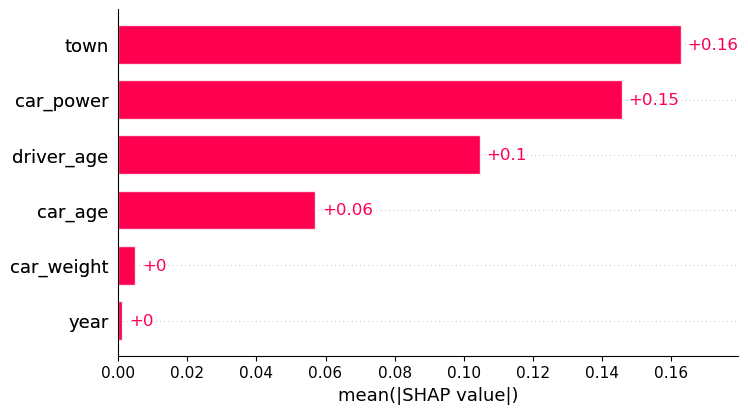

In [44]:
shap.plots.bar(shap_val)

#### SHAP dependence

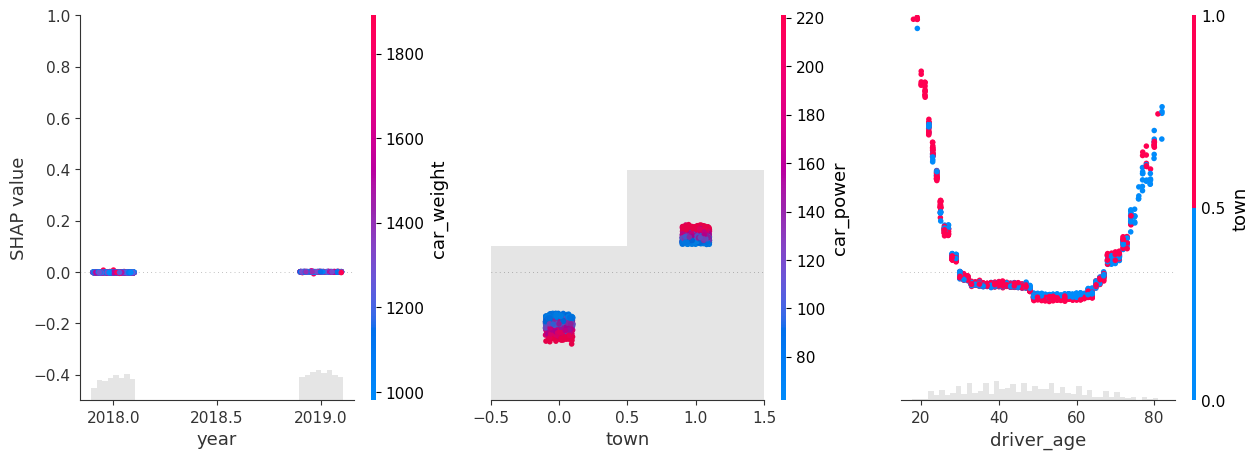

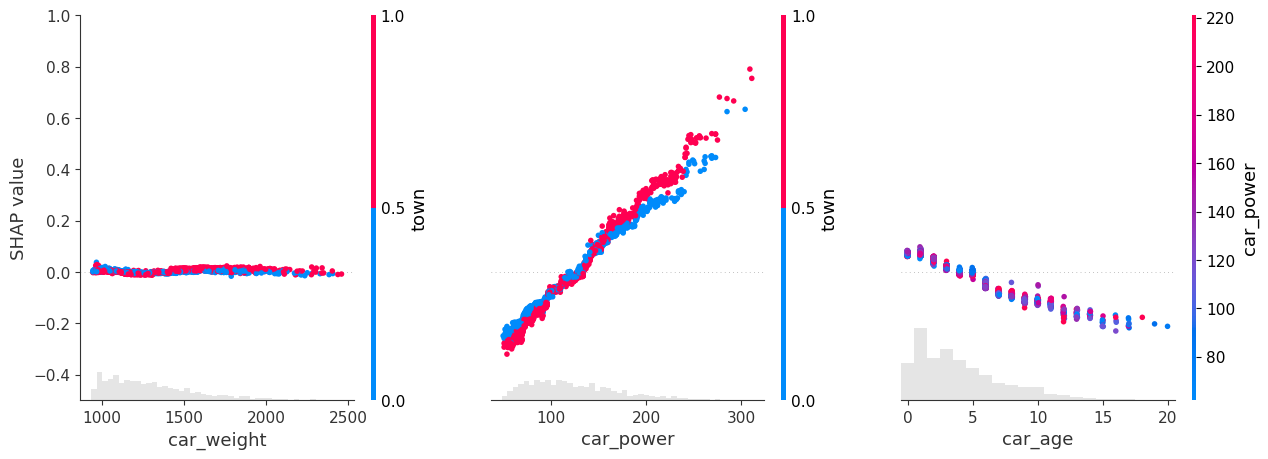

In [45]:
shap.plots.scatter(shap_val[:, 0:3], color=shap_val, ymin=-0.5, ymax=1)
shap.plots.scatter(shap_val[:, 3:], color=shap_val, ymin=-0.5, ymax=1)

## Interaction constraints

Some tree boosting implementations (LightGBM, XGBoost, HistGradientBoostingXYZ) offer to specify interaction constraints. 

- Interaction constraints are specified as list of feature sets that are allowed to interact. 
- We will focus on the simple case where feature sets are disjoint. In this case, interaction constraints work as follows: Each tree will first split on the best feature and subsequently use only features from its set.
- **Example:** `[[0], [2], [5], [1, 3, 4]]` means that features 0, 2, 5 are modeled without interaction (i.e. additively), while features 1, 3, 4 are allowed to interact. Consequently, there are trees that only use feature 0, trees that only use feature 2, trees that only use feature 5, and trees that use features 1, 3, 4.
- The effect of an additively modeled feature can be exactly described, e.g., by a PDP, a single ICE curve, or a SHAP dependence plot. They all agree up to a vertical shift.
- If your model should be additive in all features, instead of using interaction constraints, you can set `max_depth = 1` or `num_leaves=3`.
- Question: How can you build a model additive in features 0, 2, 5, and has pairwise interactions between the other features?

### Let's implement above example

For simplicity, we don't select new hyper-parameters. But in practice, we should! Typically, setting interaction constraints will require more boosting rounds to compensate for suppressed interactions.

In [46]:
params_ic = params | {"interaction_constraints": [[0], [2], [5], [1, 3, 4]]}  # Mind the positions...
params_ic

{'learning_rate': 0.05,
 'objective': 'poisson',
 'metric': 'poisson',
 'num_leaves': 7,
 'min_child_samples': 50,
 'min_child_weight': 0.001,
 'colsample_bynode': 0.8,
 'subsample': 0.8,
 'reg_alpha': 3,
 'reg_lambda': 5,
 'verbose': -1,
 'interaction_constraints': [[0], [2], [5], [1, 3, 4]]}

In [47]:
model_ic = LGBMRegressor(n_estimators=num_rounds, **params_ic, n_jobs=7)
model_ic.fit(X_train, y_train)

LGBMRegressor(colsample_bynode=0.8,
              interaction_constraints=[[0], [2], [5], [1, 3, 4]],
              learning_rate=0.05, metric='poisson', min_child_samples=50,
              n_estimators=360, n_jobs=7, num_leaves=7, objective='poisson',
              reg_alpha=3, reg_lambda=5, subsample=0.8, verbose=-1)

### SHAP dependence

SHAP dependence plots exactly describe the additive feature effects. There is no vertical scatter visible anymore (at given x value). In constrast to SHAP dependence plots with interactions, the effect can be read "ceteris paribus".

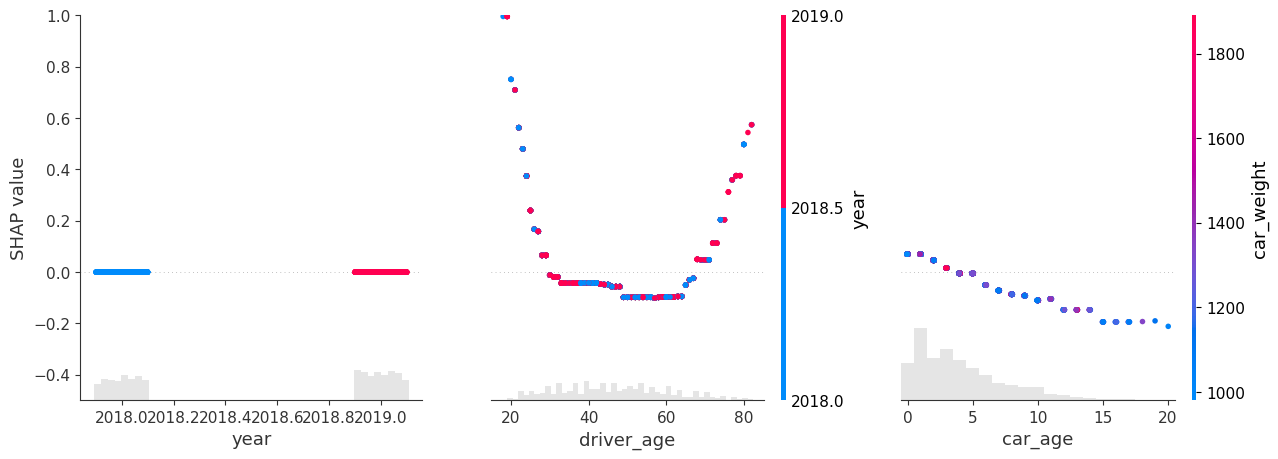

In [48]:
explainer_ic = shap.Explainer(model_ic)
shap_val_ic = explainer_ic(X_explain)

shap.plots.scatter(shap_val_ic[:, [0, 2, 5]], color=shap_val_ic, ymin=-0.5, ymax=1)

### PDP and ICE

The PDP and ICE plots below are on original scale, unlike SHAP dependence plots that are on log scale. If we would show PDP and ICE on log scale, they would indeed agree to the SHAP dependence plot (up to vertical shift).

Note. Instead of `year`, we will have a look at ICE/PDP of `car_power`. It will become relevant below when we study monotonicity.

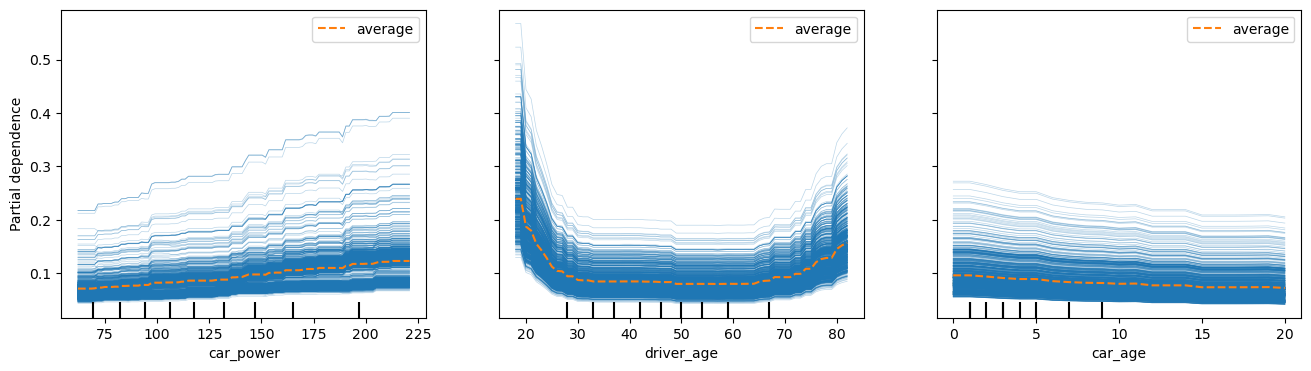

In [49]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(16, 4), nrows=1)

_ = PartialDependenceDisplay.from_estimator(
    model_ic, X_explain, ["car_power", "driver_age", "car_age"], kind="both", ax=ax
)

## Monotone constraints

A second way to bring structure to a boosted trees model is to use monotonic constraints. This is useful when the prediction function should be monotonic in a feature $X_j$, ceteris paribus.

How are monotonic constraints implemented?

1. Splits on $X_j$ are done only if constraint not violated.
2. What about subsequent splits? (TODO: Add more spice)

The ICE plot of `car_power` showed almost monotonic increasing curves. How can we force the curves to be perfectly monotonic? (Note that this would not necessarily make sense in this situation of TPL claims. It is simply an example.)

**Warning:** Don't impose too many monotonicity constraints: Counter example: are apartment prices really monotonically increasing in the number of rooms, keeping the living area fixed? No!

In [50]:
params_mc = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, -1]}  # Mind the positions...

model_mc = LGBMRegressor(n_estimators=num_rounds, **params_mc, n_jobs=7)
model_mc.fit(X_train, y_train)

LGBMRegressor(colsample_bynode=0.8,
              interaction_constraints=[[0], [2], [5], [1, 3, 4]],
              learning_rate=0.05, metric='poisson', min_child_samples=50,
              monotone_constraints=[0, 0, 0, 0, 1, -1], n_estimators=360,
              n_jobs=7, num_leaves=7, objective='poisson', reg_alpha=3,
              reg_lambda=5, subsample=0.8, verbose=-1)

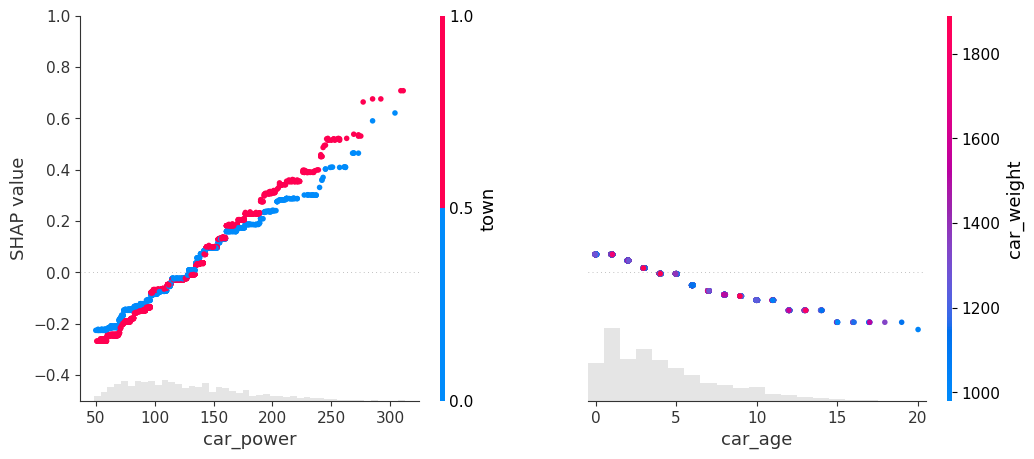

In [51]:
explainer_mc = shap.Explainer(model_mc)
shap_val_mc = explainer_mc(X_explain)

shap.plots.scatter(shap_val_mc[:, [4, 5]], color=shap_val_mc, ymin=-0.5, ymax=1)

**Comments** 

- SHAP dependence plots show forced monotonicity only for additively modeled features. Otherwise, the vertical scatter of the interactions mask it.
- PDP and ICE curves *are* perfectly monotonic (no matter if there are interactions involved or not), see below.

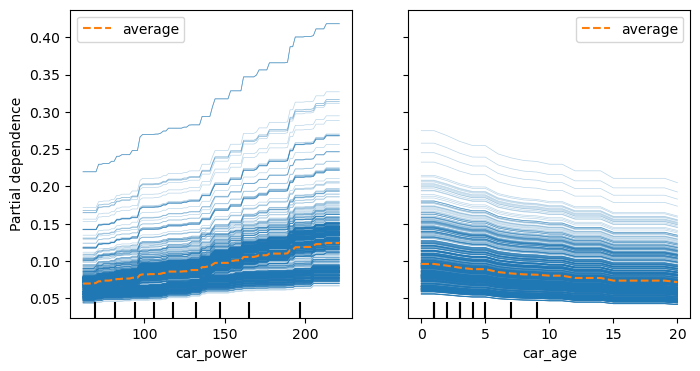

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))

_ = PartialDependenceDisplay.from_estimator(
    model_mc, X_explain, ["car_power", "car_age"], kind="both", ax=ax
)

## Monotonic constraints gone wrong

Define them correctly!

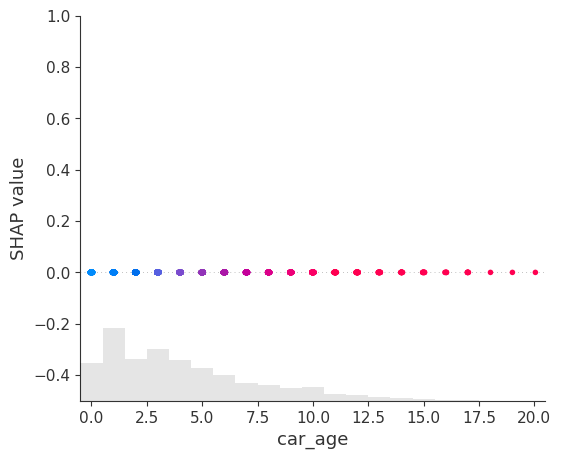

In [53]:
params_mc2 = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, 1]}  # Oops

model_mc2 = LGBMRegressor(n_estimators=num_rounds, **params_mc2, n_jobs=7)
model_mc2.fit(X_train, y_train)

explainer_mc2 = shap.Explainer(model_mc2)
shap_val_mc2 = explainer_mc2(X_explain)

shap.plots.scatter(shap_val_mc2[:, [5]], color=shap_val_mc2, ymin=-0.5, ymax=1)